<a href="https://colab.research.google.com/github/Kushan1001/NYC-Taxi-Trip-Time-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

##**Set Up**

In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import datetime as dt

import warnings; warnings.filterwarnings('ignore')



# setting some display options

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["legend.title_fontsize"] = 15


##**Loading the dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# creating a pandas data-frame (taxi_df) for the dataset

taxi_df = pd.read_csv('/content/drive/MyDrive/Capstone project -2/NYC Taxi Data.csv', index_col ='id' )

##**Exploring the dataset**

In [4]:
# checking the first five columns of the dataset

taxi_df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
# a glance of the whole dataset

taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458644 entries, id2875421 to id1209952
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   pickup_datetime     1458644 non-null  object 
 2   dropoff_datetime    1458644 non-null  object 
 3   passenger_count     1458644 non-null  int64  
 4   pickup_longitude    1458644 non-null  float64
 5   pickup_latitude     1458644 non-null  float64
 6   dropoff_longitude   1458644 non-null  float64
 7   dropoff_latitude    1458644 non-null  float64
 8   store_and_fwd_flag  1458644 non-null  object 
 9   trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [6]:
# checking the number of observations and features

print(taxi_df.shape)
print('Number of observations :', taxi_df.shape[0])
print('Number of features :', taxi_df.shape[1])

(1458644, 10)
Number of observations : 1458644
Number of features : 10


In [7]:
# features in the dataset

taxi_df.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

In [8]:
# checking the null values

taxi_df.isnull().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

We have zero null values in the dataset

In [9]:
taxi_df.nunique().sort_values()

vendor_id                   2
store_and_fwd_flag          2
passenger_count            10
trip_duration            7417
pickup_longitude        23047
dropoff_longitude       33821
pickup_latitude         45245
dropoff_latitude        62519
pickup_datetime       1380222
dropoff_datetime      1380377
dtype: int64



*   There are two types of vendores:- 1 and 2
*   Store and fwd flag takes two types of values:- Y and N
*   Passenger count takes 10 different values






In [10]:
# getting a descriptive summary of our dataset

taxi_df.describe().applymap('{:,.5f}'.format)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,"1,458,644.00000","1,458,644.00000","1,458,644.00000","1,458,644.00000","1,458,644.00000","1,458,644.00000","1,458,644.00000"
mean,1.53495,1.66453,-73.97349,40.75092,-73.97342,40.75180,959.49227
std,0.49878,1.31424,0.07090,0.03288,0.07064,0.03589,"5,237.43172"
min,1.00000,0.00000,-121.93334,34.35970,-121.93330,32.18114,1.00000
25%,1.00000,1.00000,-73.99187,40.73735,-73.99133,40.73588,397.00000
50%,2.00000,1.00000,-73.98174,40.75410,-73.97975,40.75452,662.00000
75%,2.00000,2.00000,-73.96733,40.76836,-73.96301,40.76981,"1,075.00000"
max,2.00000,9.00000,-61.33553,51.88108,-61.33553,43.92103,"3,526,282.00000"



*   Passenegrs count takes values b/w 0-9, average passengers being either 1 or 2.
*   Max trip duration is 3526282 seconds or 980 hours aprrox which is not feasible. Clearly, there are some outliers present.




##**Feature Creation**



* Now we will convert pick and drop datetime from object type to python datetime.
* It helps us to perform a lot more operations and makes our analysis better.  



In [11]:
taxi_df['dropoff_datetime'] = pd.to_datetime(taxi_df['dropoff_datetime'])
taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['pickup_datetime'])

taxi_df[['dropoff_datetime', 'pickup_datetime']].dtypes

dropoff_datetime    datetime64[ns]
pickup_datetime     datetime64[ns]
dtype: object

## Now let's extract

In [12]:
#weekday
taxi_df['pickup_weekday'] = taxi_df['pickup_datetime'].dt.weekday
taxi_df['dropoff_weekday'] = taxi_df['dropoff_datetime'].dt.weekday

#day
taxi_df['pickup_day'] = taxi_df['pickup_datetime'].dt.day
taxi_df['dropoff_day'] = taxi_df['dropoff_datetime'].dt.day


#month
taxi_df['pickup_month'] = taxi_df['pickup_datetime'].dt.month
taxi_df['dropoff_month'] = taxi_df['dropoff_datetime'].dt.month


#year
taxi_df['pickup_year'] = taxi_df['pickup_datetime'].dt.year
taxi_df['dropoff_year'] = taxi_df['dropoff_datetime'].dt.year


#hour
taxi_df['pickup_hour'] = taxi_df['pickup_datetime'].dt.hour
taxi_df['dropoff_hour'] = taxi_df['dropoff_datetime'].dt.hour



## Now let's calculate distance travelled

To calculate distance we will be using haversine formula

In [13]:
# intsalling the haversine library

!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
# importing the library

from haversine import haversine

In [15]:
''' creating a new column trip distance which the stores total distance travelled calculated using the
 haversine library'''

'''the distance calculated will be in kms'''

taxi_df['trip_distance'] = taxi_df.apply(lambda x: haversine((x['pickup_latitude'], x['pickup_longitude']),
                                                        (x['dropoff_latitude'], x['dropoff_longitude']), unit = 'km'), axis = 1)

In [16]:
taxi_df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,dropoff_weekday,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_year,dropoff_year,pickup_hour,dropoff_hour,trip_distance
id,,,,,,,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,...,0,14,14,3,3,2016,2016,17,17,1.498523
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,...,6,12,12,6,6,2016,2016,0,0,1.805510
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,...,1,19,19,1,1,2016,2016,11,12,6.385107
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,...,2,6,6,4,4,2016,2016,19,19,1.485500
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,...,5,26,26,3,3,2016,2016,13,13,1.188590


##**Preprocessing**

Since we have already extracted from pickup and dropoff datetime, let's drop these columns

In [17]:
taxi_df.drop(columns = ['pickup_datetime', 'dropoff_datetime'], inplace = True)

Now we will covert the column store and fwd flag in binary values 0 and 1

In [18]:
''' store and fwd flag takes only two values N and Y. So we can encode them as 0 for N
 and 1 for Y'''

print(taxi_df['store_and_fwd_flag'].unique())

['N' 'Y']


We will do this with the of python class LabelEncoder

In [19]:
from sklearn.preprocessing import LabelEncoder # importing the class LabelEncoder

label_encoder = LabelEncoder() # creating an object of class labelEncoder 

taxi_df['store_and_fwd_flag'] = label_encoder.fit_transform(taxi_df['store_and_fwd_flag']) # apply the method fit_transform of LabelEncoder
                                                                                           # to convert them into binary values

In [20]:
print(taxi_df['store_and_fwd_flag'].unique())

[0 1]


##**Exploratory Data Analysis**

##Checking for Outliers

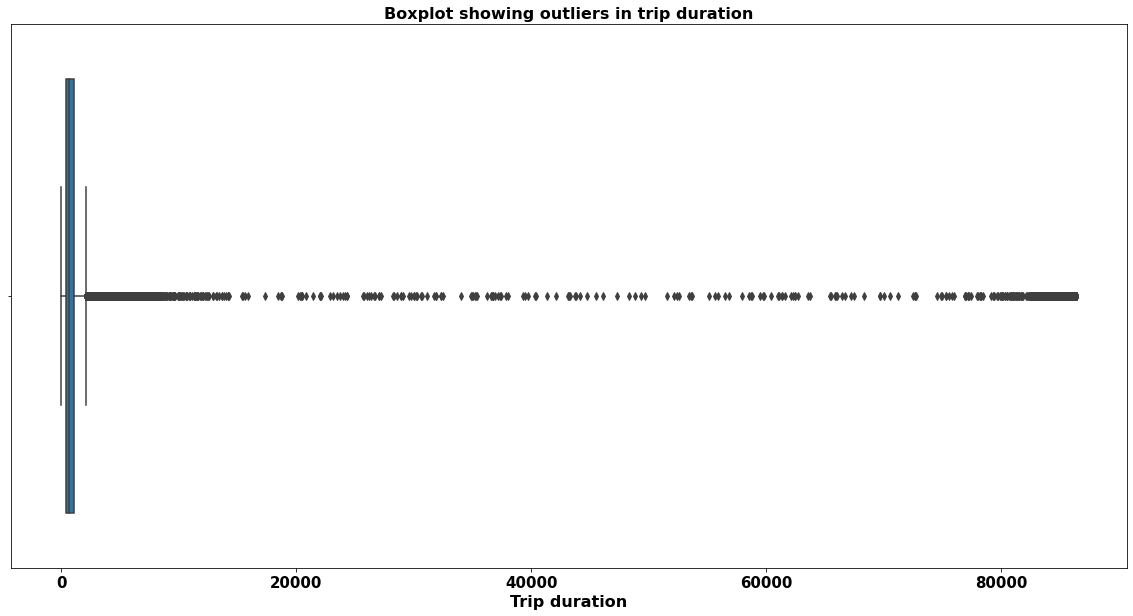

In [80]:
rcParams['figure.figsize'] = 20,10

sns.boxplot(taxi_df['trip_duration'])
plt.xlabel('Trip duration')
plt.title('Boxplot showing outliers in trip duration');

From the boxplot we can see that there are some trips which are around 2000000 seconds or 555 hours and beyond. Clearly, it's not feasible for a taxi to run that long. Hence we will get rid of such trips.

In [22]:
taxi_df['trip_duration'].sort_values(ascending = False)

id
id0053347    3526282
id1325766    2227612
id0369307    2049578
id1864733    1939736
id1942836      86392
              ...   
id0553321          1
id0008221          1
id3563137          1
id2697717          1
id2959956          1
Name: trip_duration, Length: 1458644, dtype: int64

In [23]:
# There are major differences b/w trip durations after 'id1942836'. Thus, we will remove the trips after that id

taxi_df.drop(taxi_df[taxi_df['trip_duration'] == 3526282].index, inplace = True)
taxi_df.drop(taxi_df[taxi_df['trip_duration'] == 2227612].index, inplace = True)
taxi_df.drop(taxi_df[taxi_df['trip_duration'] == 2049578].index, inplace = True)
taxi_df.drop(taxi_df[taxi_df['trip_duration'] == 1939736].index, inplace = True)


##Univariate Analysis

###Average trip duration

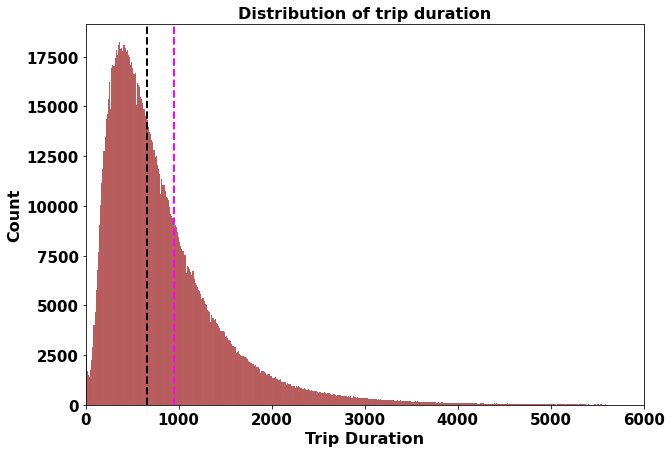

In [24]:
rcParams['figure.figsize'] = 10,7

sns.histplot(data = taxi_df, x= 'trip_duration', color = 'brown')
plt.xlim(0,6000)
plt.xlabel('Trip Duration')
plt.axvline(taxi_df['trip_duration'].mean(), linestyle = 'dashed', color = 'magenta', linewidth = 2)
plt.axvline(taxi_df['trip_duration'].median(), linestyle = 'dashed', color = 'black', linewidth = 2)
plt.title('Distribution of trip duration')
plt.show();

##**Insights**


*   Average trip duration is around 500 seconds or 8.5 minutes 



###Distribution of Vendor ID

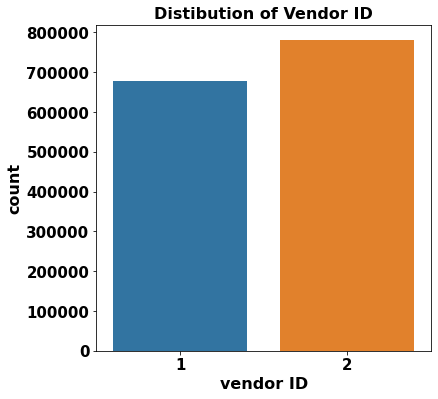

In [25]:
rcParams['figure.figsize'] = 6,6

sns.countplot(taxi_df['vendor_id'])
plt.title('Distibution of Vendor ID')
plt.xlabel('vendor ID')
plt.show();

###**Insights**

*  From the plot we can infer that vendor-2 is more preferred by the people of New York




###Distribution of passenger count 

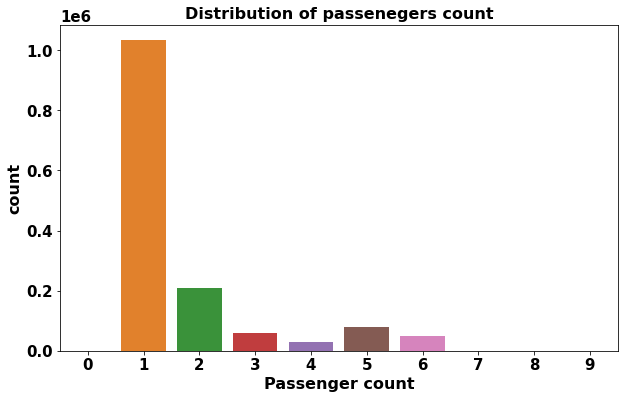

In [26]:
rcParams['figure.figsize'] = 10,6

sns.countplot(taxi_df['passenger_count'])
plt.title('Distribution of passenegers count')
plt.xlabel('Passenger count')
plt.show();

###**Insights**

* Above barplot shows us that the most trips are done by either 1 or 2 passengers at a time




###Distribution of pickup latitude

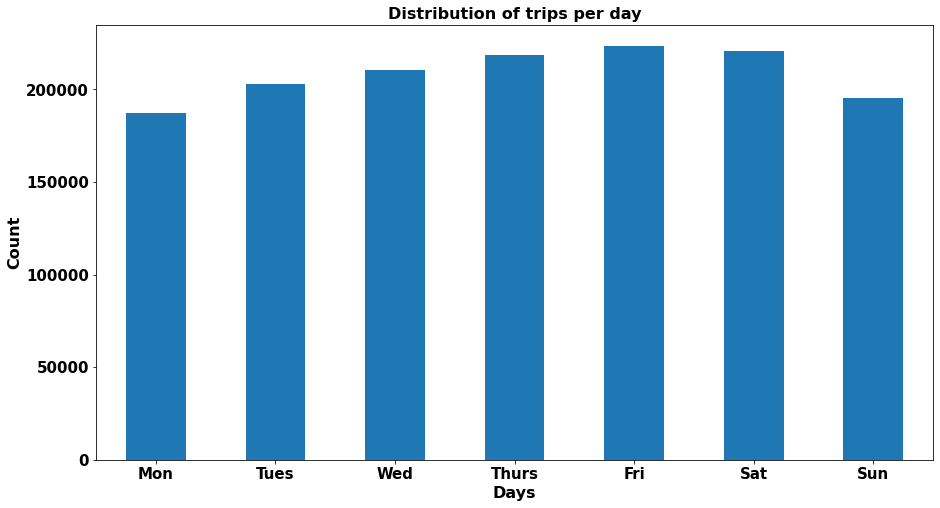

In [27]:
plt.figure(figsize=(15 , 8))

pickups_by_weekdays = taxi_df['pickup_weekday'].value_counts()
pickups_by_weekdays.sort_index().plot(kind = 'bar')
plt.title('Distribution of trips per day')
plt.xticks(rotation = 0, ticks= [0,1,2,3,4,5,6], labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Days')
plt.ylabel('Count')
plt.show();

###**Insights**


*   Thurday, Friday and Saturday are the preferred for riding a cab

*   Monday and Sunday are least preferred by New Yorkers



###Distribution of Pickup hours


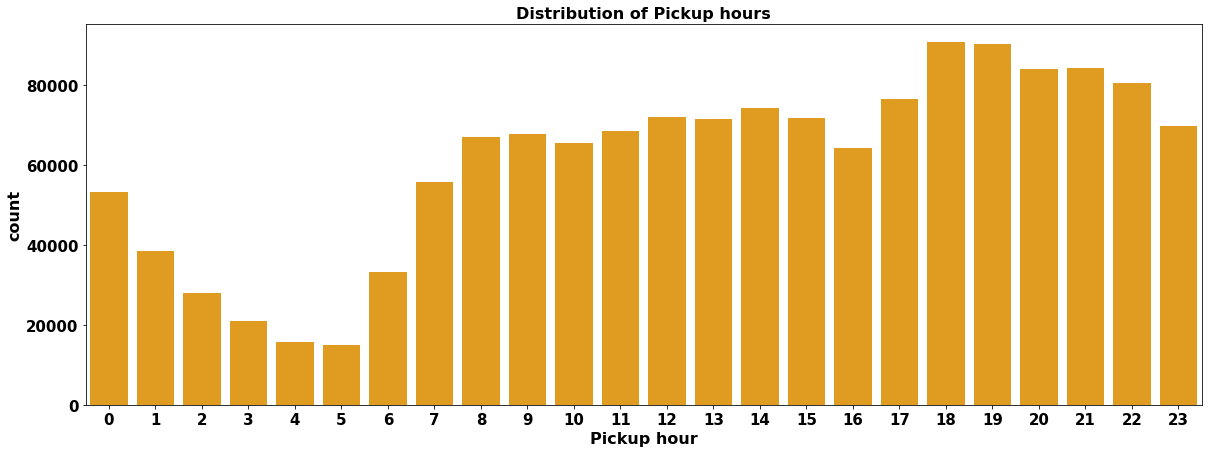

In [28]:
rcParams['figure.figsize'] = 20,7 

sns.countplot(data = taxi_df, x= 'pickup_hour', color = 'orange')
plt.title('Distribution of Pickup hours')
plt.xlabel('Pickup hour')
plt.show();

###**Insights**


*   People prefers taxis from 8 in the morning (probably office hours) and this growth increases with time.

*   6-7 in evening is the most preferred time by the new yorkers

* This graph also shows that new yorkers also prefer riding a cab at night as well 10pm - 12am




###Distribution of pickup month

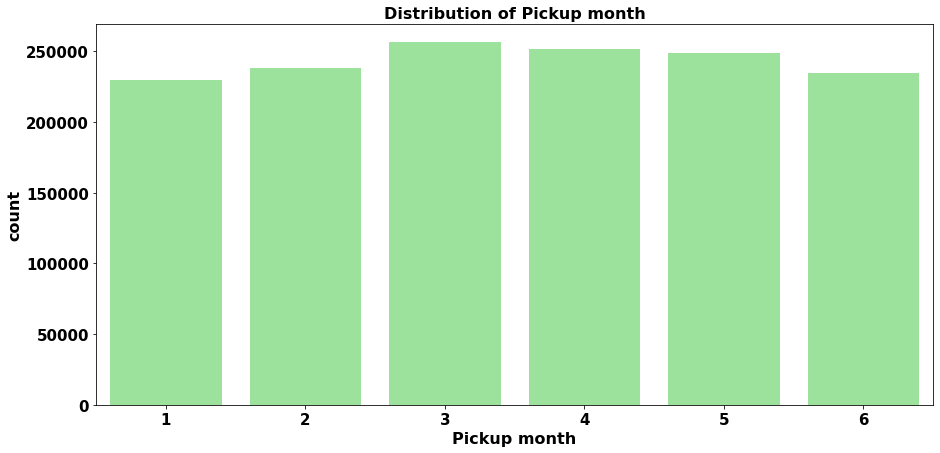

In [73]:
rcParams['figure.figsize'] = 15,7 

sns.countplot(data = taxi_df, x= 'pickup_month', color = 'lightgreen')
plt.title('Distribution of Pickup month')
plt.xlabel('Pickup month')
plt.show();

###**Insights**


*   Most new yorkers prefer riding a cab in March and April, closely followed by February and May




###Distribution of pickup day

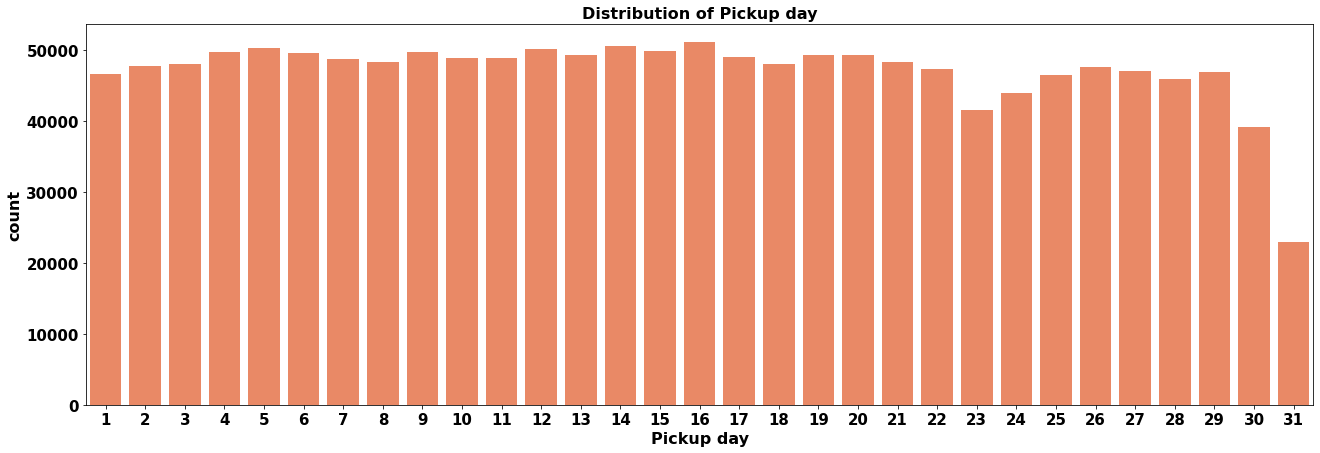

In [76]:
rcParams['figure.figsize'] = 22,7 

sns.countplot(data = taxi_df, x= 'pickup_day', color = 'coral')
plt.title('Distribution of Pickup day')
plt.xlabel('Pickup day')
plt.show();

###**Insights**


*   All the days of a month are more or less evenly distributed except for 30th and 31st that witnesses a sharp decline in taxi rides.




###Average trip distance

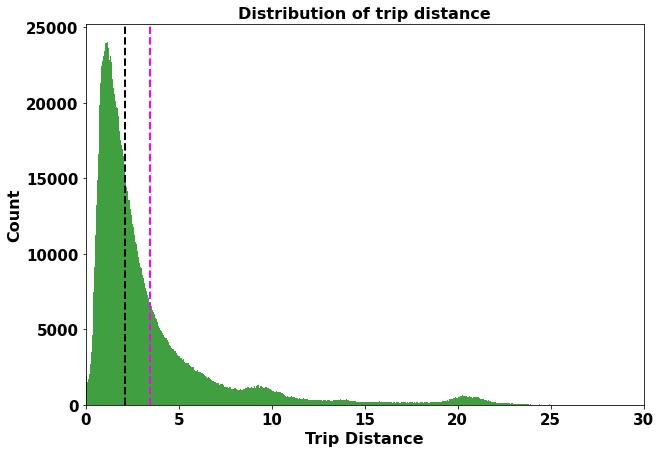

In [29]:
rcParams['figure.figsize'] = 10,7

sns.histplot(data = taxi_df, x= 'trip_distance', color = 'green')
plt.xlim(0,30)
plt.xlabel('Trip Distance')
plt.axvline(taxi_df['trip_distance'].mean(), linestyle = 'dashed', color = 'magenta', linewidth = 2)
plt.axvline(taxi_df['trip_distance'].median(), linestyle = 'dashed', color = 'black', linewidth = 2)
plt.title('Distribution of trip distance')
plt.show();

###**Insights**

Average trip distance is around 3-4km which is reasonable since our trips last only for 7-8 minutes

##Distribiution of store and fwd flag

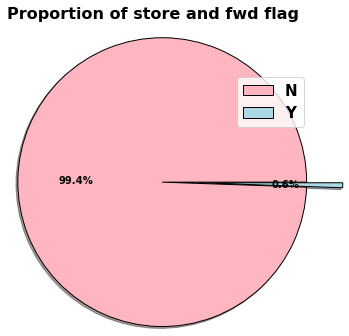

In [30]:
rcParams['figure.figsize'] = 5,5

explode = [0.4,0]
colors = ['lightpink','lightblue']
plt.pie(taxi_df['store_and_fwd_flag'].value_counts(), wedgeprops={'edgecolor':'black'},autopct='%1.1f%%',
        explode = explode, radius = 1.6,colors = colors, shadow = 'True')

plt.title('Proportion of store and fwd flag', x = 0.3, y= 1.2)
plt.legend(labels=['N','Y'])


plt.tight_layout();

##**Insights**


* From the piechart we can see that less than 1% of trips are stored and forward trips



##Bivariate Analysis

###Relationship b/w Vendor ID and trip duration

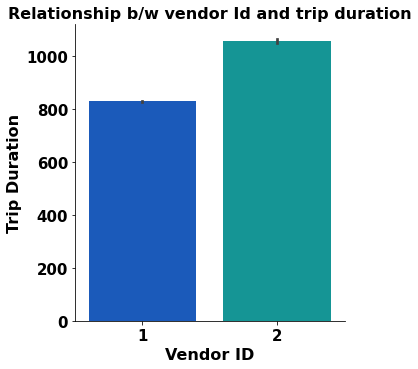

In [68]:
rcParams['figure.figsize'] = 15,10

sns.catplot(data = taxi_df, x = 'vendor_id', y = 'trip_duration', 
            palette = 'winter', kind = 'bar')
plt.title('Relationship b/w vendor Id and trip duration')
plt.ylabel('Trip Duration')
plt.xlabel('Vendor ID')
plt.show();


###**Insights**

* It can clearly seen that the vendor 2 gets trips with more duration relative to the vendor 1

###Relationship b/w store and fwd trip and trip duration

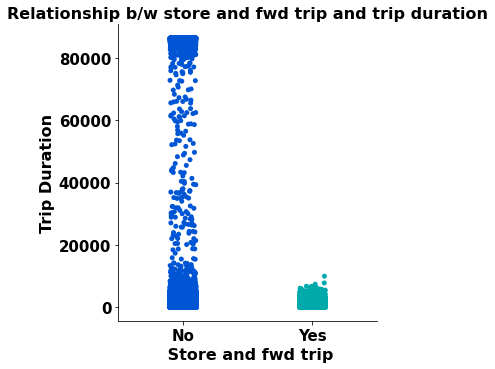

In [86]:
rcParams['figure.figsize'] = 15,10

sns.catplot(data = taxi_df, x = 'store_and_fwd_flag', y = 'trip_duration', 
            palette = 'winter', kind = 'strip', jitter = True)
plt.title('Relationship b/w store and fwd trip and trip duration')
plt.ylabel('Trip Duration')
plt.xlabel(' Store and fwd trip')
plt.xticks(ticks = [0,1], labels = ['No', 'Yes'])
plt.show();

###**Insights**


*   Trips which are not stored and forwarded have longer duration relative to trips which are stored and forwared.




###Relationship b/w Passeneger count and Trip duration

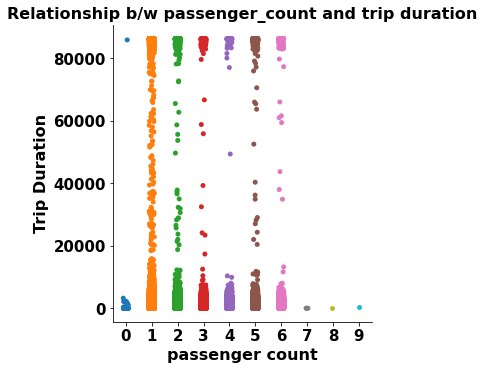

In [88]:
rcParams['figure.figsize'] = 15,10

sns.catplot(data = taxi_df, x = 'passenger_count', y = 'trip_duration', 
           kind = 'strip', jitter = True)
plt.title('Relationship b/w Passenger_count and trip duration')
plt.ylabel('Trip Duration')
plt.xlabel('Passenger count')
plt.show();

###**Insights**


*   There is no clear correlation b/w passengers and trip duration




###Relationship b/w Pickup weekday and Trip duaration


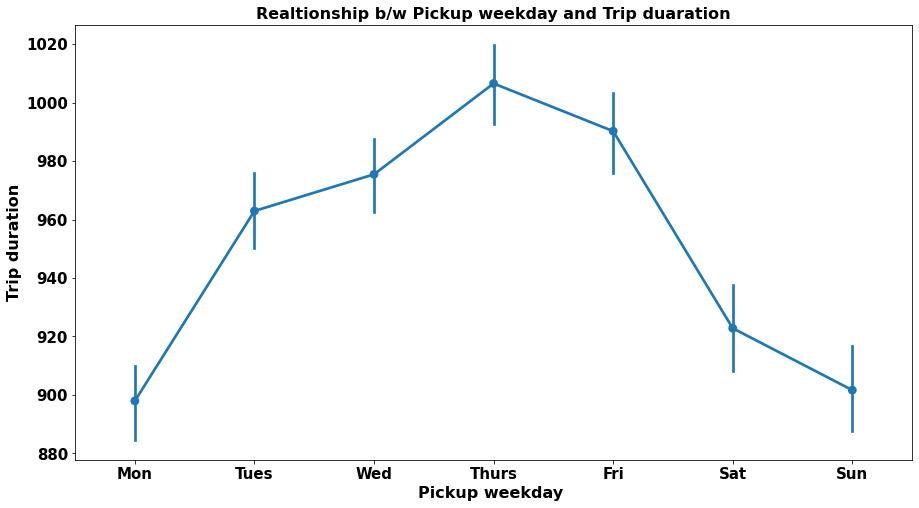

In [56]:
rcParams['figure.figsize'] = 15,8

sns.pointplot(data =taxi_df, x = 'pickup_weekday', y = 'trip_duration')

plt.title('Realtionship b/w Pickup weekday and Trip duaration')
plt.xlabel('Pickup weekday ')
plt.ylabel('Trip duration')
plt.xticks(ticks = [0,1,2,3,4,5,6], labels = ['Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat','Sun'])
plt.show();


##**Insights**


* On Thursday new yorkers longest duration trips, followed by Friday and Wednesday

* However, on weekends new yorkers prefer shortest duration trips



###Relationship b/w Pickup hour and Trip duration

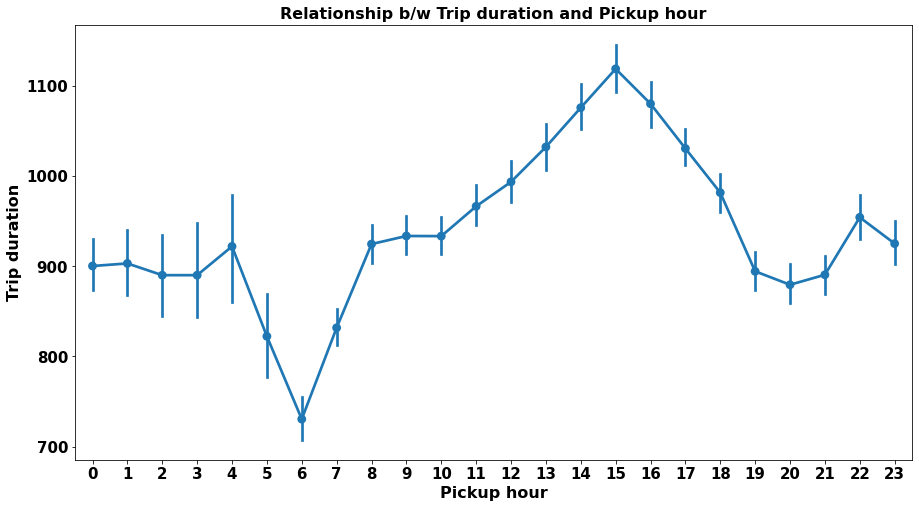

In [57]:
rcParams['figure.figsize'] = 15,8

sns.pointplot(data =taxi_df, x = 'pickup_hour', y = 'trip_duration')

plt.title('Relationship b/w Pickup hour and Trip duration')
plt.xlabel('Pickup hour')
plt.ylabel('Trip duration')
plt.show();

##**Insights**


*   During afternoons (14-16 or 2pm-4pm) we see the longest duration trips.
*   On the other hand, during early mornings (6am) we see the shortest duration trips



###Relationship b/w Pickup month and Trip duration

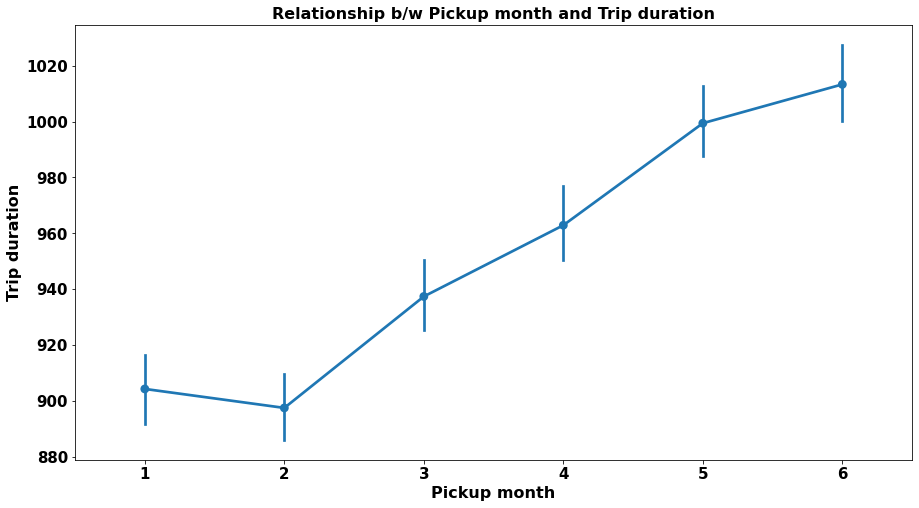

In [61]:
rcParams['figure.figsize'] = 15,8

sns.pointplot(data =taxi_df, x = 'pickup_month', y = 'trip_duration')

plt.title('Relationship b/w Pickup month and Trip duration')
plt.xlabel('Pickup month')
plt.ylabel('Trip duration')
plt.show();

##**Insights**


*   Duaration of trips increase with every next month. However, after reaching the 6th month or June the rate of increase has slightly slowed down.




###Relationship b/w Pickup day and Trip duration

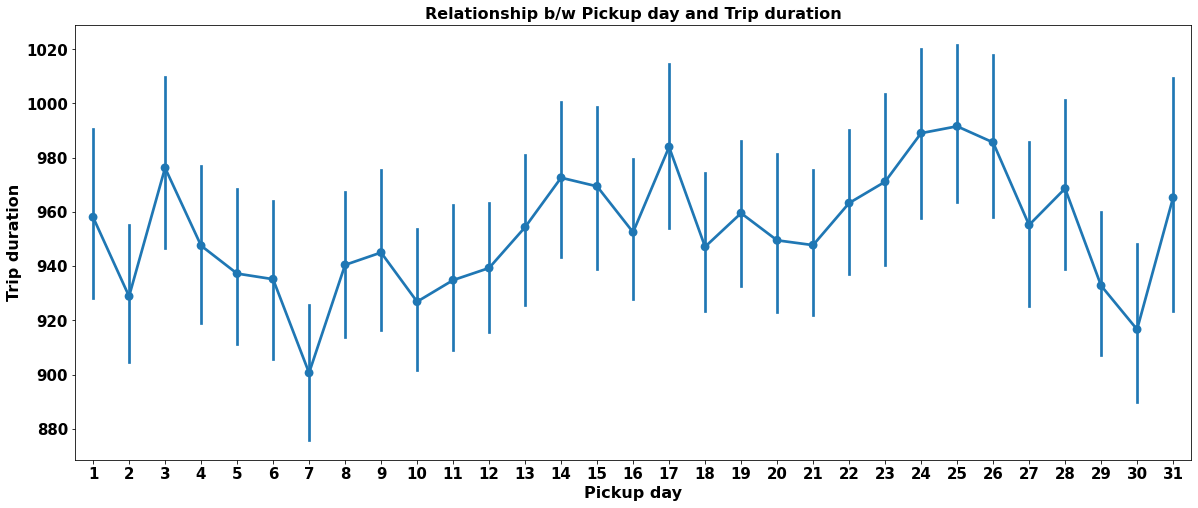

In [63]:
rcParams['figure.figsize'] = 20,8

sns.pointplot(data =taxi_df, x = 'pickup_day', y = 'trip_duration')

plt.title('Relationship b/w Pickup day and Trip duration')
plt.xlabel('Pickup day')
plt.ylabel('Trip duration')
plt.show();

###**Insights**


*   On 7th and 30th trip duration is at its lowest.
*   However, on 3rd, 17, 24th, 25th and 26th trip duration is the highest.



###Relationship b/w Pickup latitude and longitude & Trip duration

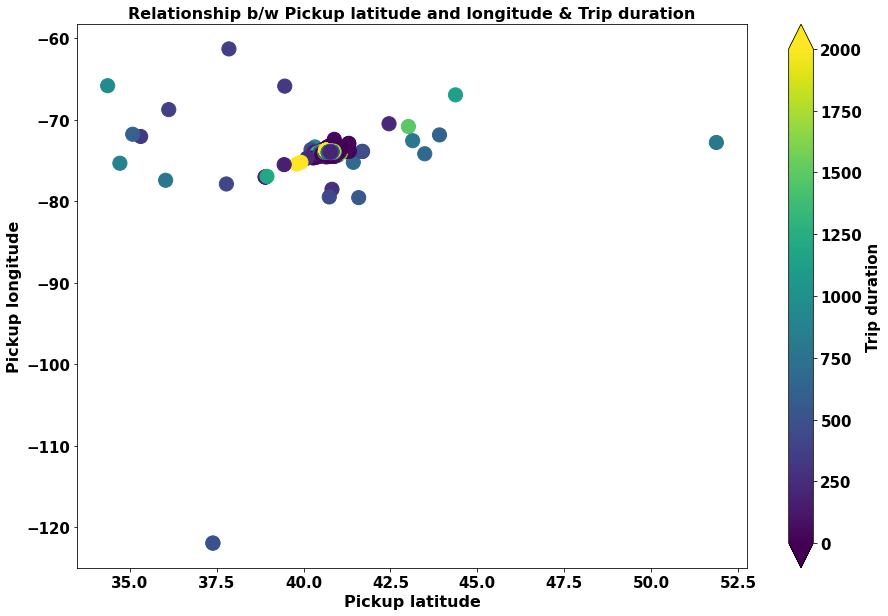

In [107]:
plt.scatter(data = taxi_df, x = 'pickup_latitude', y = 'pickup_longitude', c = 'trip_duration', s = 200)
cbar = plt.colorbar(orientation = 'vertical', extend = 'both', pad = 0.05, aspect = 20 )
cbar.set_label(label = 'Trip duration', size = 15, x = 1.5)
plt.xlabel('Pickup latitude')
plt.ylabel('Pickup longitude')
plt.title('Relationship b/w Pickup latitude and longitude & Trip duration')
plt.clim(0,2000)
plt.show();

###**Insights**


*   Generally pickups are concentrated between latittude(40-42.5 degrees) and longitude(-75 degrees) are their trip duration is generally between 0-1000 seconds



###Relationship b/w Dropoff latitude and longitude & Trip duration

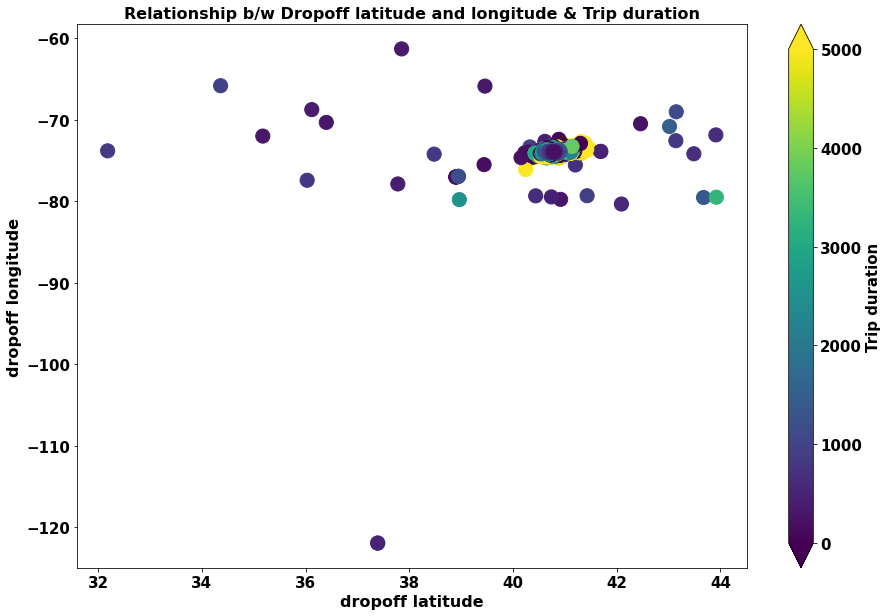

In [110]:
plt.scatter(data = taxi_df, x = 'dropoff_latitude', y = 'dropoff_longitude', c = 'trip_duration', s = 200)
cbar = plt.colorbar(orientation = 'vertical', extend = 'both', pad = 0.05, aspect = 20 )
cbar.set_label(label = 'Trip duration', size = 15, x = 1.5)
plt.xlabel('dropoff latitude')
plt.ylabel('dropoff longitude')
plt.title('Relationship b/w Dropoff latitude and longitude & Trip duration')
plt.clim(0,5000)
plt.show();

###**Insights**


*   Generally dropoffs are concentrated between latittude(40-42 degrees) and longitude(-72 degrees) are their trip duration is generally between 0-2000 seconds.


